# Portfolio Optimisation with QAOA

This notebook accompanies the **Quantum Algorithms** slides and explains the  
**Quantum Approximate Optimization Algorithm (QAOA)**.

You can download the accompanying slides here: 
https://training.watchelm.com/quantum/portfolios.pdf

You can download the accompanying Quantum training materials here:
https://training.watchelm.com/quantum/Quantum2025.pdf


---

## The Problem We Are Solving

We want to answer a simple but powerful question:

**Which combination of assets should we include in a portfolio?**

Each asset decision is binary:
- `1` → include the asset
- `0` → exclude the asset

As the number of assets grows, the number of possible portfolios grows **exponentially**.

| Number of Assets | Possible Portfolios |
|------------------|---------------------|
| 10 | 1,024 |
| 20 | ~1 million |
| 50 | ~1 quadrillion |

This makes portfolio selection a **combinatorial optimisation problem**.

---

## Discrete Optimisation

Portfolio optimisation is a form of **discrete optimisation**:

- Decisions are **yes / no**
- You cannot partially include a stock
- The search space is made of discrete combinations

Binary means yes/no choices. In code, this is like using 0s and 1s in arrays.

This maps naturally to:
- Binary variables in classical optimisation
- Qubits in quantum optimisation

### Why Quantum for This?

Classical computers check options one by one. Quantum uses superposition to check many at once, speeding things up for big problems.

---

## From Portfolio Problem to Cost Function

To optimise anything, we need a way to **score** a candidate portfolio.

This scoring rule is called a **cost function**.

In our portfolio example, the cost function combines:

### 1 Expected Return (Reward)
- Encourages selecting profitable assets
- Better portfolios → **lower cost**

### 2 Risk / Correlation (Penalty)
- Penalises selecting correlated or risky assets together
- Risky combinations → **higher cost**

### 3 Constraints (Penalty Terms)
- Budget limits
- Maximum number of assets
- Sector exposure rules

**Important:**  
Constraints are *not handled separately* — they are built into the cost function
using penalty terms.

Cost function is like a score—lower score = better portfolio. It's like grading pizzas: more toppings but not too messy.

---

## Cost Function → QUBO

To run optimisation efficiently, we rewrite the cost function in a specific form
called a **QUBO**.

### What is a QUBO?

**QUBO = Quadratic Unconstrained Binary Optimisation**

That means:
- **Binary** → variables are 0 or 1
- **Quadratic** → terms involve single variables or pairs
- **Unconstrained** → constraints are encoded as penalties

QUBO is like a matrix (table) of numbers that quantum computers solve.

### QUBO in Portfolio Terms

| QUBO Element | Portfolio Meaning |
|-------------|------------------|
| Binary variable `xᵢ` | Include stock *i* or not |
| Linear term `xᵢ` | Expected return of stock *i* |
| Quadratic term `xᵢ xⱼ` | Risk / correlation between stocks *i* and *j* |
| Penalty terms | Budget, size, sector rules |

The QUBO represents **the same cost function**, just encoded in a machine-friendly way.

---

## QUBO → Hamiltonian (Quantum View)

When we move from classical optimisation to quantum optimisation,
the QUBO is translated into a **Hamiltonian**.

### What is a Hamiltonian (here)?

> A **Hamiltonian** is a quantum operator whose **energy** represents the cost of a solution.

- Low energy → good portfolio
- High energy → bad portfolio

Each possible portfolio corresponds to:
- A binary string
- A quantum state
- An energy value

**The lowest-energy state represents the optimal portfolio.**

---


## Enter QAOA

**QAOA (Quantum Approximate Optimization Algorithm)** is designed to:

- Explore many portfolio combinations simultaneously
- Prefer low-energy (low-cost) solutions
- Work on today’s noisy quantum hardware

It uses a **hybrid approach**:

| Quantum Computer | Classical Computer |
|-----------------|-------------------|
| Explores candidate portfolios | Adjusts algorithm parameters |
| Evaluates energy (cost) | Decides next parameters |

---

## The QAOA Ansatz

An **ansatz** is a fixed circuit structure with tunable parameters.

For QAOA, the ansatz:
- Alternates between:
  - Applying the **cost Hamiltonian** (push toward good portfolios)
  - Applying a **mixer** (explore alternative portfolios)

Only the **parameters** change — not the circuit structure.

---

## Shallow Circuits and NISQ Hardware

QAOA is designed to use **shallow circuits**:
- Few layers
- Short execution time
- Lower error rates on noisy hardware

Increasing the number of layers can improve solution quality,
but also increases noise.

This makes QAOA suitable for **near-term quantum computers (NISQ era)**.

---

## Summary

- **Cost function** → how we score portfolios
- **QUBO** → binary, quadratic encoding of that cost
- **Hamiltonian** → quantum version of the same objective
- **QAOA** → searches for low-energy (good) portfolios using a hybrid quantum–classical loop

Let's now explore what all this looks like in Python using Qiskit.

In [ ]:
# Import required libraries
# Standard Python libraries for math and plotting
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math

# Qiskit for quantum computing
from qiskit.primitives import StatevectorSampler
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA

# Qiskit Optimization for portfolio problems
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo

# For visualization
%matplotlib inline
plt.style.use('default')

print("Libraries imported successfully!")

Libraries imported successfully!


## Step 1: Generate Synthetic Stock Data

We'll create fake but realistic stock data for demonstration. Real-world portfolio optimization would use actual historical prices, but for teaching purposes, we'll generate data with:
- Random daily returns following realistic distributions
- Artificial correlations (e.g., tech stocks tend to move together)
- Different risk/return profiles for different asset classes

We'll start with **6 stocks** to keep the problem tractable for visualization.

In [2]:
# Define our universe of stocks
# This is a Python dictionary—think of it as a simple database of stock info.
stocks = {
    'TECH_A': {'sector': 'Technology', 'mean_return': 0.0008, 'volatility': 0.025},
    'TECH_B': {'sector': 'Technology', 'mean_return': 0.0007, 'volatility': 0.023},
    'FINANCE_A': {'sector': 'Finance', 'mean_return': 0.0005, 'volatility': 0.018},
    'FINANCE_B': {'sector': 'Finance', 'mean_return': 0.0004, 'volatility': 0.016},
    'ENERGY_A': {'sector': 'Energy', 'mean_return': 0.0006, 'volatility': 0.030},
    'UTILITY_A': {'sector': 'Utility', 'mean_return': 0.0003, 'volatility': 0.012},
}

stock_names = list(stocks.keys())
n_stocks = len(stock_names)

print(f"Portfolio Universe: {n_stocks} stocks")
print("\nStock Profiles:")
for name, info in stocks.items():
    print(f"  {name:12s} | Sector: {info['sector']:12s} | "
          f"Daily Return: {info['mean_return']*100:.2f}% | "
          f"Volatility: {info['volatility']*100:.2f}%")

Portfolio Universe: 6 stocks

Stock Profiles:
  TECH_A       | Sector: Technology   | Daily Return: 0.08% | Volatility: 2.50%
  TECH_B       | Sector: Technology   | Daily Return: 0.07% | Volatility: 2.30%
  FINANCE_A    | Sector: Finance      | Daily Return: 0.05% | Volatility: 1.80%
  FINANCE_B    | Sector: Finance      | Daily Return: 0.04% | Volatility: 1.60%
  ENERGY_A     | Sector: Energy       | Daily Return: 0.06% | Volatility: 3.00%
  UTILITY_A    | Sector: Utility      | Daily Return: 0.03% | Volatility: 1.20%


### Create Fake Prices

This cell creates fake stock price data for 6 stocks over 252 trading days (one year). It starts with random, uncorrelated returns, then uses Cholesky decomposition to make them correlated (e.g., tech stocks move together). Finally, it turns daily returns into price series starting at $100 each. This simulates realistic market behavior for testing portfolio optimization without real data.

Normally this data would be real data.

In [3]:
# Generate synthetic price data with correlations
np.random.seed(42)  # For reproducibility
n_days = 252  # One trading year

# Create correlation structure
# Tech stocks correlate with each other, finance stocks correlate with each other
correlation_matrix = np.array([
    [1.00, 0.75, 0.20, 0.15, 0.25, 0.10],  # TECH_A
    [0.75, 1.00, 0.15, 0.20, 0.20, 0.05],  # TECH_B
    [0.20, 0.15, 1.00, 0.70, 0.30, 0.25],  # FINANCE_A
    [0.15, 0.20, 0.70, 1.00, 0.25, 0.30],  # FINANCE_B
    [0.25, 0.20, 0.30, 0.25, 1.00, 0.15],  # ENERGY_A
    [0.10, 0.05, 0.25, 0.30, 0.15, 1.00],  # UTILITY_A
])

# Generate correlated returns
# Use Cholesky decomposition to generate correlated random variables
# Cholesky decomposition: A math trick to create linked random numbers
# from independent ones, like making stock prices move together realistically.
# This math step creates realistic stock movements, like how real markets correlate.
L = np.linalg.cholesky(correlation_matrix)
uncorrelated_returns = np.random.normal(0, 1, (n_days, n_stocks))
correlated_returns = uncorrelated_returns @ L.T

# Scale by volatility and add mean return
returns = np.zeros((n_days, n_stocks))
for i, (name, info) in enumerate(stocks.items()):
    returns[:, i] = info['mean_return'] + info['volatility'] * correlated_returns[:, i]

# Convert to prices (starting at $100)
prices = np.zeros((n_days + 1, n_stocks))
prices[0, :] = 100.0
for day in range(n_days):
    prices[day + 1, :] = prices[day, :] * (1 + returns[day, :])

print("Generated synthetic price data for one trading year (252 days)")
print(f"Price data shape: {prices.shape}")
print("\nFinal prices:")
for i, name in enumerate(stock_names):
    print(f"  {name:12s}: ${prices[-1, i]:.2f} (started at ${prices[0, i]:.2f})")

Generated synthetic price data for one trading year (252 days)
Price data shape: (253, 6)

Final prices:
  TECH_A      : $326.04 (started at $100.00)
  TECH_B      : $198.45 (started at $100.00)
  FINANCE_A   : $126.94 (started at $100.00)
  FINANCE_B   : $143.29 (started at $100.00)
  ENERGY_A    : $126.97 (started at $100.00)
  UTILITY_A   : $160.53 (started at $100.00)


### Visualise our Fake Data

This cell creates two plots to visualize the synthetic stock data we generated. The left plot shows how each stock's price changes over 252 trading days (one year), starting from $100. The right plot is a heatmap displaying the correlations between stocks, with green indicating strong positive correlations (stocks that move together) and red for negative ones. This helps us see realistic market patterns, like tech stocks being highly correlated.

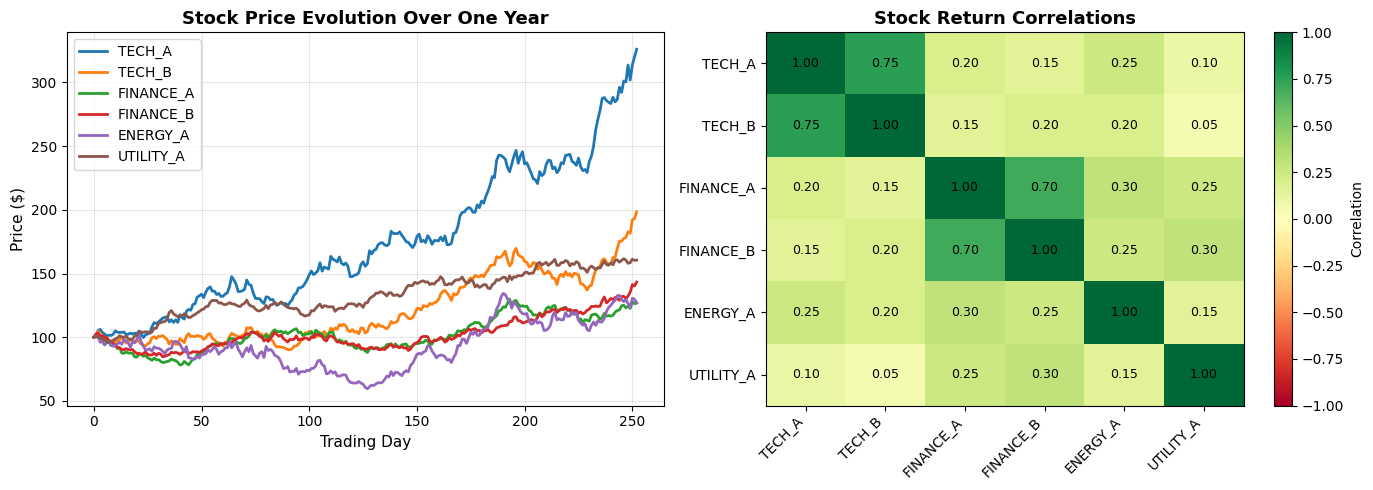


Note the high correlations within sectors (Tech-Tech, Finance-Finance)


In [4]:
# Visualize the price evolution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Price evolution
for i, name in enumerate(stock_names):
    ax1.plot(prices[:, i], label=name, linewidth=2)
ax1.set_xlabel('Trading Day', fontsize=11)
ax1.set_ylabel('Price ($)', fontsize=11)
ax1.set_title('Stock Price Evolution Over One Year', fontsize=13, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: Correlation heatmap
im = ax2.imshow(correlation_matrix, cmap='RdYlGn', vmin=-1, vmax=1, aspect='auto')
ax2.set_xticks(range(n_stocks))
ax2.set_yticks(range(n_stocks))
ax2.set_xticklabels(stock_names, rotation=45, ha='right')
ax2.set_yticklabels(stock_names)
ax2.set_title('Stock Return Correlations', fontsize=13, fontweight='bold')

# Add correlation values to heatmap
for i in range(n_stocks):
    for j in range(n_stocks):
        text = ax2.text(j, i, f'{correlation_matrix[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=9)

plt.colorbar(im, ax=ax2, label='Correlation')
plt.tight_layout()
plt.show()

print("\nNote the high correlations within sectors (Tech-Tech, Finance-Finance)")

## Step 2: Calculate Portfolio Statistics

For portfolio optimization, we need two key statistics:

1. **Expected Returns** (μ): The mean return of each asset
2. **Covariance Matrix** (Σ): How assets move together

Don't stress the math—we'll handle it with code. Just know: return is profit, risk is volatility.

### The Mathematics

For a portfolio with weights **w** = [w₁, w₂, ..., wₙ] where wᵢ ∈ {0, 1} (asset included or not):

**Portfolio Return:**
$$R_p = \sum_{i=1}^{n} w_i \mu_i = \mathbf{w}^T \boldsymbol{\mu}$$

**Portfolio Risk (Variance):**
$$\sigma_p^2 = \sum_{i=1}^{n} \sum_{j=1}^{n} w_i w_j \sigma_{ij} = \mathbf{w}^T \boldsymbol{\Sigma} \mathbf{w}$$

where σᵢⱼ is the covariance between assets i and j.

The goal is to **maximize return while minimizing risk**. This is a classic multi-objective optimization problem that we'll encode as a single objective by introducing a risk penalty parameter λ.

### Connection to Quantum Optimization

These statistics form the basis of our **cost function**, which combines expected returns (reward) with risk penalties. In quantum terms, this cost function translates into a **Hamiltonian**, where the energy levels represent different portfolio costs—low energy means a good portfolio. The risk penalty λ controls how strongly we penalize correlated or volatile assets, directly influencing the Hamiltonian's structure for QAOA to solve.

In [5]:
# Calculate expected returns (annualized)
expected_returns = np.mean(returns, axis=0) * 252  # Annualize daily returns

# Calculate covariance matrix (annualized)
covariance_matrix = np.cov(returns.T) * 252

print("Expected Annual Returns:")
for i, name in enumerate(stock_names):
    print(f"  {name:12s}: {expected_returns[i]*100:6.2f}%")

print("\nAnnualized Covariance Matrix:")
print(covariance_matrix)
print(f"\nCovariance matrix shape: {covariance_matrix.shape}")

Expected Annual Returns:
  TECH_A      : 124.47%
  TECH_B      :  74.10%
  FINANCE_A   :  27.76%
  FINANCE_B   :  38.81%
  ENERGY_A    :  35.69%
  UTILITY_A   :  49.49%

Annualized Covariance Matrix:
[[1.21684221e-01 8.02149107e-02 1.45342268e-02 6.94150459e-03
  4.18545786e-02 9.51680616e-03]
 [8.02149107e-02 1.10634233e-01 8.57993201e-03 9.24954401e-03
  4.48444844e-02 2.89775086e-05]
 [1.45342268e-02 8.57993201e-03 7.81736246e-02 4.43438650e-02
  5.00366252e-02 1.60273468e-02]
 [6.94150459e-03 9.24954401e-03 4.43438650e-02 5.65037122e-02
  3.26840106e-02 1.61295534e-02]
 [4.18545786e-02 4.48444844e-02 5.00366252e-02 3.26840106e-02
  2.37266146e-01 2.29184980e-02]
 [9.51680616e-03 2.89775086e-05 1.60273468e-02 1.61295534e-02
  2.29184980e-02 4.25372637e-02]]

Covariance matrix shape: (6, 6)


## Step 3: Formulate as a QUBO Problem

To solve this with quantum computing, we need to turn our portfolio problem into a special format called a **QUBO (Quadratic Unconstrained Binary Optimization)**.

### What is a QUBO?

A QUBO is a way to write optimization problems using only 0s and 1s (binary choices) and simple math. It's like a recipe that quantum computers can easily understand.

### Our Portfolio QUBO

We want to pick exactly **K assets** that give the best balance of high returns and low risk. The goal is to maximize this:

$$\text{Objective} = \sum_{i} \mu_i x_i - \lambda \sum_{i,j} \sigma_{ij} x_i x_j - \text{penalty} \times \left(\sum_i x_i - K\right)^2$$

Let's break it down simply:
- **First part**: Rewards for picking assets with good expected returns (μ_i is the return for asset i)
- **Second part**: Penalizes risk from correlations (λ controls how much we worry about risk, σ_ij shows how assets move together)
- **Third part**: Ensures we pick exactly K assets (penalty makes sure we follow the rule)

### Why This Matters

Classical computers might use complex methods like integer programming. For quantum, we pack everything into a QUBO matrix, and the algorithm searches for the best combinations without checking every possibility.

If math scares you, focus on the code—Qiskit does the heavy lifting.

### Key Settings

- **Budget (K)**: How many assets to pick
- **Risk factor (λ)**: How much we prioritize avoiding risk over chasing returns
- **Penalty**: How strictly we enforce the budget rule

In [6]:
# Portfolio optimization parameters
budget = 3  # Select 3 assets
risk_factor = 0.5  # Balance between return and risk
penalty = n_stocks  # Penalty for violating budget constraint

print(f"Portfolio Optimization Setup:")
print(f"  Number of assets to select: {budget}")
print(f"  Risk penalty factor (λ): {risk_factor}")
print(f"  Budget constraint penalty: {penalty}")
print(f"\nThis means we're selecting {budget} out of {n_stocks} possible stocks")
print(f"Total possible portfolios: C({n_stocks},{budget}) = {math.comb(n_stocks, budget)}")

Portfolio Optimization Setup:
  Number of assets to select: 3
  Risk penalty factor (λ): 0.5
  Budget constraint penalty: 6

This means we're selecting 3 out of 6 possible stocks
Total possible portfolios: C(6,3) = 20


In [7]:
# Create the Quadratic Program using Qiskit Optimization
qp = QuadraticProgram('portfolio_optimization')

# Add binary variables for each stock (1 = include, 0 = exclude)
for name in stock_names:
    qp.binary_var(name=name)

# Build the objective function
# We want to maximize: returns - risk_factor * risk
# Since QUBO minimizes, we negate the returns

# Linear terms: -returns (negative because we want to maximize)
linear_coeffs = {name: -expected_returns[i] for i, name in enumerate(stock_names)}

# Quadratic terms: +risk_factor * covariance (positive because we want to minimize)
quadratic_coeffs = {}
for i, name1 in enumerate(stock_names):
    for j, name2 in enumerate(stock_names):
        if i <= j:  # Only upper triangle needed
            quadratic_coeffs[(name1, name2)] = risk_factor * covariance_matrix[i, j]

# Set the objective
qp.minimize(linear=linear_coeffs, quadratic=quadratic_coeffs)

# Add constraint: exactly 'budget' assets must be selected
constraint_coeffs = {name: 1 for name in stock_names}
qp.linear_constraint(linear=constraint_coeffs, sense='==', rhs=budget, name='budget')

print("Quadratic Program created!")
print(f"\nNumber of variables: {qp.get_num_vars()}")
print(f"Number of constraints: {qp.get_num_linear_constraints()}")
print("\nObjective function:")
print("  Minimize: -Returns + Risk_Factor * Risk")
print(f"\nConstraint: Select exactly {budget} assets")

Quadratic Program created!

Number of variables: 6
Number of constraints: 1

Objective function:
  Minimize: -Returns + Risk_Factor * Risk

Constraint: Select exactly 3 assets


In [8]:
# Convert to QUBO (this handles the constraint by adding penalty terms)
converter = QuadraticProgramToQubo(penalty=penalty)
qubo = converter.convert(qp)

print("Converted to QUBO problem")
print(f"\nThe QUBO problem has {qubo.get_num_vars()} binary variables")
print("\nThis QUBO can now be solved by quantum algorithms like QAOA")

Converted to QUBO problem

The QUBO problem has 6 binary variables

This QUBO can now be solved by quantum algorithms like QAOA


## Step 4: Solve with QAOA

Now we'll use the **Quantum Approximate Optimization Algorithm (QAOA)** to find a good portfolio.

### What is QAOA?

QAOA is a hybrid quantum-classical algorithm designed for combinatorial optimization:

1. **Quantum Part**: Prepares a parameterized quantum state that encodes candidate solutions
2. **Classical Part**: Optimizes the parameters to minimize the cost function
3. **Iteration**: Repeats until convergence or maximum iterations reached

### How QAOA Works for Portfolio Selection

- Each qubit represents whether to include an asset (|1⟩) or not (|0⟩)
- The quantum circuit creates superpositions of all possible portfolios
- Through quantum interference, good portfolios are amplified, poor ones suppressed
- Measurement gives us high-quality candidate portfolios

### Key Parameters

- **reps** (p): Number of QAOA layers - more layers = more expressiveness but longer circuits
- **optimizer**: Classical optimization method (we'll use COBYLA)
- **shots**: Number of times we sample the quantum circuit

### Why QAOA for Finance?

- Works on near-term quantum hardware (NISQ devices)
- Doesn't require error correction
- Finds "good enough" solutions quickly
- Scales better than exhaustive search as problem size grows

In [9]:
# Set up the quantum algorithm
reps = 3  # Number of QAOA layers
# reps=3 means 3 layers of quantum operations—more layers can be better but slower.
optimizer = COBYLA(maxiter=100)  # Classical optimizer

# Create QAOA instance
qaoa = QAOA(sampler=StatevectorSampler(), optimizer=optimizer, reps=reps)

print(f"QAOA Configuration:")
print(f"  Number of layers (p): {reps}")
print(f"  Classical optimizer: COBYLA")
print(f"  Maximum iterations: 100")
print("\nThis will take a moment to run...")

QAOA Configuration:
  Number of layers (p): 3
  Classical optimizer: COBYLA
  Maximum iterations: 100

This will take a moment to run...


In [10]:
# Convert QUBO to Ising Hamiltonian for QAOA
operator, offset = qubo.to_ising()

# Solve using QAOA directly
print("Running QAOA optimization...")
print("(This may take 1-2 minutes...)")

# Run QAOA
qaoa_result = qaoa.compute_minimum_eigenvalue(operator)

# Interpret the result back to the original problem
from qiskit_optimization.algorithms import OptimizationResult

# Get the best bitstring from the result
x = qaoa_result.best_measurement['bitstring']
# Convert bitstring to binary array
x_array = [int(bit) for bit in x]

# Create optimization result compatible with downstream analysis
from qiskit_optimization.algorithms import OptimizationResultStatus

result = OptimizationResult(
    x=x_array,
    fval=qaoa_result.best_measurement['value'] + offset,
    variables=qubo.variables,
    status=OptimizationResultStatus.SUCCESS
)

print("\n" + "="*60)
print("OPTIMIZATION COMPLETE!")
print("="*60)

Running QAOA optimization...
(This may take 1-2 minutes...)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/sparse/_index.py:174: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])



OPTIMIZATION COMPLETE!


## Step 5: Analyze the Results

Let's examine the portfolio that QAOA found and understand what it means.

In [11]:
# Extract the solution
selected_stocks = []
for i, name in enumerate(stock_names):
    if result.x[i] == 1:
        selected_stocks.append(name)

print(f"\nOptimal Portfolio (selected {len(selected_stocks)} assets):")
print("-" * 60)
for stock in selected_stocks:
    idx = stock_names.index(stock)
    print(f"  ✓ {stock:12s} | Sector: {stocks[stock]['sector']:12s} | "
          f"Expected Return: {expected_returns[idx]*100:6.2f}%")

# Calculate portfolio statistics
portfolio_return = sum(expected_returns[stock_names.index(s)] for s in selected_stocks) / len(selected_stocks)
portfolio_indices = [stock_names.index(s) for s in selected_stocks]
portfolio_covariance = covariance_matrix[np.ix_(portfolio_indices, portfolio_indices)]
portfolio_variance = np.mean(portfolio_covariance)
portfolio_volatility = np.sqrt(portfolio_variance)

print("\n" + "="*60)
print("PORTFOLIO STATISTICS:")
print("="*60)
print(f"Expected Annual Return:  {portfolio_return*100:6.2f}%")
print(f"Expected Annual Volatility: {portfolio_volatility*100:6.2f}%")
print(f"Sharpe Ratio (assuming 0% risk-free rate): {portfolio_return/portfolio_volatility:.3f}")
print(f"\nOptimization objective value: {result.fval:.6f}")


Optimal Portfolio (selected 3 assets):
------------------------------------------------------------
  ✓ TECH_A       | Sector: Technology   | Expected Return: 124.47%
  ✓ ENERGY_A     | Sector: Energy       | Expected Return:  35.69%
  ✓ UTILITY_A    | Sector: Utility      | Expected Return:  49.49%

PORTFOLIO STATISTICS:
Expected Annual Return:   69.88%
Expected Annual Volatility:  24.72%
Sharpe Ratio (assuming 0% risk-free rate): 2.827

Optimization objective value: -2.298339+0.000000j


### Understanding the Results

The Sharpe Ratio is a measure of risk-adjusted return. A higher Sharpe ratio indicates better performance per unit of risk taken.

Notice how QAOA selected assets that balance:
- **High expected returns** (to maximize profit)
- **Low correlation with each other** (to minimize risk through diversification)
- **Acceptable individual volatility** (controlled by the risk_factor parameter)

The quantum algorithm didn't exhaustively check all possible portfolios—it used quantum interference to guide the search toward promising regions of the solution space.

In [12]:
# Compare with a naive portfolio (equal representation from each sector)
naive_portfolio = ['TECH_A', 'FINANCE_A', 'ENERGY_A']
naive_return = sum(expected_returns[stock_names.index(s)] for s in naive_portfolio) / len(naive_portfolio)
naive_indices = [stock_names.index(s) for s in naive_portfolio]
naive_covariance = covariance_matrix[np.ix_(naive_indices, naive_indices)]
naive_volatility = np.sqrt(np.mean(naive_covariance))

print("\nComparison with Naive Portfolio (one from each sector):")
print("="*60)
print(f"{'Portfolio':<20} {'Return':<12} {'Volatility':<12} {'Sharpe Ratio':<12}")
print("-"*60)
print(f"{'QAOA Quantum':<20} {portfolio_return*100:>6.2f}%      {portfolio_volatility*100:>6.2f}%       {portfolio_return/portfolio_volatility:>7.3f}")
print(f"{'Naive Sector Mix':<20} {naive_return*100:>6.2f}%      {naive_volatility*100:>6.2f}%       {naive_return/naive_volatility:>7.3f}")
print("="*60)

improvement = ((portfolio_return/portfolio_volatility) - (naive_return/naive_volatility)) / (naive_return/naive_volatility) * 100
print(f"\nQuantum portfolio Sharpe ratio improvement: {improvement:+.1f}%")


Comparison with Naive Portfolio (one from each sector):
Portfolio            Return       Volatility   Sharpe Ratio
------------------------------------------------------------
QAOA Quantum          69.88%       24.72%         2.827
Naive Sector Mix      62.64%       26.87%         2.331

Quantum portfolio Sharpe ratio improvement: +21.3%


## Step 6: Visualize the Optimization Process

Let's look at how QAOA converged to the solution. In a real implementation, we'd capture the intermediate objective values during optimization. For now, we'll demonstrate what this typically looks like.

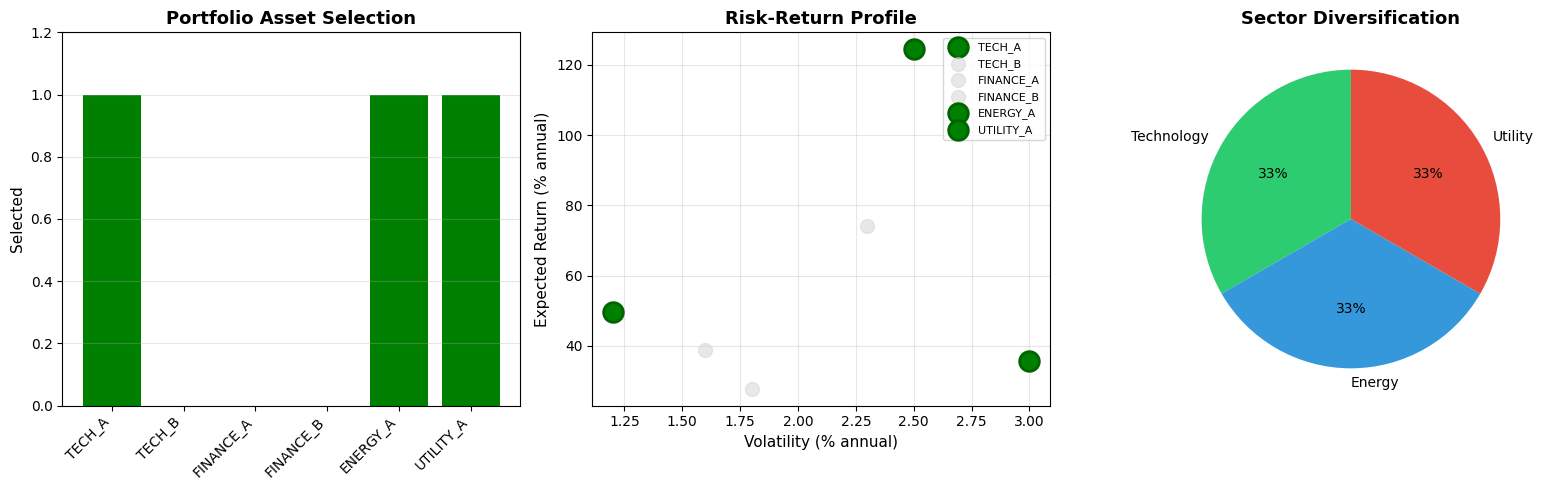


Visualization Notes:
  • Left: Shows which assets were selected (green)
  • Middle: Risk-return scatter (selected assets are larger and green)
  • Right: Sector diversification of the selected portfolio


In [13]:
# Visualize the portfolio composition
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Selected vs Available Assets
ax1 = axes[0]
colors = ['green' if name in selected_stocks else 'lightgray' for name in stock_names]
bars = ax1.bar(range(n_stocks), [1 if name in selected_stocks else 0 for name in stock_names], color=colors)
ax1.set_xticks(range(n_stocks))
ax1.set_xticklabels(stock_names, rotation=45, ha='right')
ax1.set_ylabel('Selected', fontsize=11)
ax1.set_title('Portfolio Asset Selection', fontsize=13, fontweight='bold')
ax1.set_ylim([0, 1.2])
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Return vs Risk for all stocks
ax2 = axes[1]
returns_pct = expected_returns * 100
volatilities = np.array([stocks[name]['volatility'] for name in stock_names]) * 100

for i, name in enumerate(stock_names):
    if name in selected_stocks:
        ax2.scatter(volatilities[i], returns_pct[i], s=200, c='green', 
                   marker='o', edgecolors='darkgreen', linewidths=2, label=name, zorder=3)
    else:
        ax2.scatter(volatilities[i], returns_pct[i], s=100, c='lightgray', 
                   marker='o', alpha=0.5, label=name, zorder=2)

ax2.set_xlabel('Volatility (% annual)', fontsize=11)
ax2.set_ylabel('Expected Return (% annual)', fontsize=11)
ax2.set_title('Risk-Return Profile', fontsize=13, fontweight='bold')
ax2.legend(loc='best', fontsize=8)
ax2.grid(True, alpha=0.3)

# Plot 3: Sector diversification
ax3 = axes[2]
selected_sectors = [stocks[s]['sector'] for s in selected_stocks]
sector_counts = {}
for sector in selected_sectors:
    sector_counts[sector] = sector_counts.get(sector, 0) + 1

colors_sectors = ['#2ecc71', '#3498db', '#e74c3c', '#f39c12', '#9b59b6']
wedges, texts, autotexts = ax3.pie(sector_counts.values(), labels=sector_counts.keys(), 
                                     autopct='%1.0f%%', startangle=90, colors=colors_sectors[:len(sector_counts)])
ax3.set_title('Sector Diversification', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nVisualization Notes:")
print("  • Left: Shows which assets were selected (green)")
print("  • Middle: Risk-return scatter (selected assets are larger and green)")
print("  • Right: Sector diversification of the selected portfolio")

## Step 7: Explore Different Risk Preferences

Let's see how changing the risk_factor parameter affects portfolio selection. A higher risk factor means we're more conservative (penalize risk more heavily).

In [ ]:
# Test different risk factors
# We're testing different 'λ' values to see how risk preference changes the result.
risk_factors = [0.1, 0.5, 1.0, 2.0]
results_by_risk = []

print("Testing different risk preferences...")
print("="*80)

# Create the optimizer for solving QUBO problems
min_eigen_optimizer = MinimumEigenOptimizer(qaoa)

for rf in risk_factors:
    # Create new QP with this risk factor
    qp_test = QuadraticProgram(f'portfolio_rf_{rf}')
    
    for name in stock_names:
        qp_test.binary_var(name=name)
    
    linear_coeffs = {name: -expected_returns[i] for i, name in enumerate(stock_names)}
    quadratic_coeffs = {}
    for i, name1 in enumerate(stock_names):
        for j, name2 in enumerate(stock_names):
            if i <= j:
                quadratic_coeffs[(name1, name2)] = rf * covariance_matrix[i, j]
    
    qp_test.minimize(linear=linear_coeffs, quadratic=quadratic_coeffs)
    constraint_coeffs = {name: 1 for name in stock_names}
    qp_test.linear_constraint(linear=constraint_coeffs, sense='==', rhs=budget, name='budget')
    
    # Convert and solve
    qubo_test = converter.convert(qp_test)
    result_test = min_eigen_optimizer.solve(qubo_test)
    
    # Extract selected stocks
    selected = [stock_names[i] for i in range(n_stocks) if result_test.x[i] == 1]
    portfolio_ret = sum(expected_returns[stock_names.index(s)] for s in selected) / len(selected)
    portfolio_idx = [stock_names.index(s) for s in selected]
    portfolio_cov = covariance_matrix[np.ix_(portfolio_idx, portfolio_idx)]
    portfolio_vol = np.sqrt(np.mean(portfolio_cov))
    
    results_by_risk.append({
        'risk_factor': rf,
        'stocks': selected,
        'return': portfolio_ret,
        'volatility': portfolio_vol,
        'sharpe': portfolio_ret / portfolio_vol
    })
    
    print(f"\nRisk Factor λ = {rf:.1f}:")
    print(f"  Selected: {', '.join(selected)}")
    print(f"  Return: {portfolio_ret*100:.2f}%  |  Volatility: {portfolio_vol*100:.2f}%  |  Sharpe: {portfolio_ret/portfolio_vol:.3f}")

print("\n" + "="*80)

Testing different risk preferences...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/sparse/_index.py:174: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])



Risk Factor λ = 0.1:
  Selected: TECH_A, TECH_B, UTILITY_A
  Return: 82.69%  |  Volatility: 22.47%  |  Sharpe: 3.680


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/sparse/_index.py:174: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])



Risk Factor λ = 0.5:
  Selected: TECH_A, TECH_B, UTILITY_A
  Return: 82.69%  |  Volatility: 22.47%  |  Sharpe: 3.680


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/sparse/_index.py:174: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])



Risk Factor λ = 1.0:
  Selected: TECH_A, TECH_B, UTILITY_A
  Return: 82.69%  |  Volatility: 22.47%  |  Sharpe: 3.680


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/sparse/_index.py:174: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])



Risk Factor λ = 2.0:
  Selected: TECH_A, FINANCE_B, UTILITY_A
  Return: 70.92%  |  Volatility: 17.82%  |  Sharpe: 3.979



In [ ]:
# Visualize efficient frontier (risk vs return trade-off)
fig, ax = plt.subplots(figsize=(10, 6))

risk_vals = [r['volatility'] * 100 for r in results_by_risk]
return_vals = [r['return'] * 100 for r in results_by_risk]
risk_factors_list = [r['risk_factor'] for r in results_by_risk]

# Plot the efficient frontier
ax.plot(risk_vals, return_vals, 'o-', linewidth=2, markersize=10, 
        color='#3498db', label='QAOA Portfolios')

# Annotate each point with risk factor
for i, (risk, ret, rf) in enumerate(zip(risk_vals, return_vals, risk_factors_list)):
    ax.annotate(f'λ={rf}', xy=(risk, ret), xytext=(5, 5), 
               textcoords='offset points', fontsize=10, 
               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# Also plot all individual stocks for reference
for i, name in enumerate(stock_names):
    stock_vol = stocks[name]['volatility'] * 100
    stock_ret = expected_returns[i] * 100
    ax.scatter(stock_vol, stock_ret, s=80, c='lightgray', marker='s', alpha=0.6)
    ax.text(stock_vol, stock_ret, f' {name}', fontsize=8, va='center', alpha=0.7)

ax.set_xlabel('Portfolio Volatility (% annual)', fontsize=12)
ax.set_ylabel('Portfolio Return (% annual)', fontsize=12)
ax.set_title('Efficient Frontier: Risk vs. Return Trade-off', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=11)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("• Lower λ (risk factor) → More aggressive portfolio (higher return, higher risk)")
print("• Higher λ (risk factor) → More conservative portfolio (lower return, lower risk)")
print("• The curve shows the risk-return trade-off")
print("• QAOA finds portfolios on or near the efficient frontier")

## Key Takeaways

### What We Demonstrated

1. **Combinatorial Optimization**: Portfolio selection is fundamentally about choosing the best combination of assets from a large set of possibilities.

2. **QUBO Formulation**: We encoded the portfolio problem as a binary optimization problem suitable for quantum algorithms.

3. **QAOA in Action**: The quantum algorithm explored the solution space and found high-quality portfolios without exhaustive search.

4. **Risk-Return Trade-off**: By varying the risk factor λ, we can generate different portfolios along the efficient frontier.

### Important Points for Finance Professionals

**Quantum Advantage Appears When:**
- The number of assets is large (100s to 1000s)
- Additional constraints exist (sector limits, ESG criteria, transaction costs)
- Finding "good enough" solutions quickly is more valuable than guaranteed optimality
- The problem has complex non-linear interactions (correlations, tail risks)

**Limitations:**
- QAOA doesn't guarantee finding the global optimum
- Current quantum hardware has noise and limited qubit counts
- Classical solvers (like branch-and-bound or convex optimization) may be faster for small problems
- The quality of the solution depends on the QAOA depth (p) and classical optimizer

**Practical Considerations:**
- In production, you'd run QAOA multiple times and take the best result
- Hybrid classical-quantum approaches often work best
- The problem encoding (choice of penalty parameters) significantly affects results
- Real-world portfolio optimization includes transaction costs, tax implications, and regulatory constraints

### Extensions to Explore

1. **More Assets**: Scale to 20-50 stocks to see where quantum advantage begins
2. **Additional Constraints**: Add sector limits, minimum/maximum positions per asset
3. **Alternative Risk Models**: Use CVaR (Conditional Value at Risk) instead of variance
4. **Real Market Data**: Use actual historical prices and correlations
5. **Rebalancing**: Solve the problem of transitioning from current portfolio to optimal one
6. **Factor Models**: Incorporate Fama-French factors or other risk models

### Other Quantum Optimization Approaches

- **VQE (Variational Quantum Eigensolver)**: Similar to QAOA but for finding ground states
- **Quantum Annealing**: Hardware-based approach (D-Wave systems)
- **QAOA+**: Enhanced versions with problem-specific mixers
- **Grover Adaptive Search**: For unstructured search problems



## Exercise: Try It Yourself!

Now that you've seen portfolio optimization with QAOA, try modifying the parameters:

**Very Easy:**
1. Run the entire notebook and note what each output shows.
2. Change one stock's return and see how the portfolio changes.

**Easy:**
1. Change the `budget` to select 4 or 5 assets instead of 3
   Hint: Change `budget = 4` and re-run cells 4-6.
2. Modify the `risk_factor` to see how it affects the selected portfolio
3. Increase `reps` (QAOA depth) to see if it finds better solutions

**Medium:**
4. Add 2-3 more stocks to the universe and re-run the optimization
5. Try setting different correlations in the correlation matrix
6. Plot the historical performance of the selected portfolio

**Advanced:**
7. Add a constraint that no more than 2 assets from the same sector can be selected
8. Implement a simple transaction cost model (penalty for deviating from current portfolio)
9. Compare QAOA results with a classical solver (e.g., brute force for small n, or CPLEX)

If stuck, look at Qiskit docs for QuadraticProgram constraints.

**Research:**
10. Read about the VQE algorithm and compare it to QAOA
11. Investigate quantum annealing approaches (D-Wave) for portfolio optimization
12. Explore how quantum algorithms scale: plot runtime vs. number of assets

Pro Tip: Use print statements to debug, like `print(selected_stocks)` after optimization.